In [1]:
pip install --user scikit-learn
import sklearn
print("Sklearn verion is {}".format(sklearn.__version__))
pip install xgboost
pip install shap

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\ShineJean\anaconda3\python.exe -m pip install --upgrade pip' command.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics

import shap

## 1. Read data

In [2]:
df = pd.read_excel('./default_of_credit_card_clients.xls',sep = '\t') # read the excel file
df = df.drop('ID', axis = 1)   # drop the ID column 

# convert the long string name 'default payment next month' to 'Default_y' for convenience 
df = df.rename(columns = {'default payment next month': 'Default_y'})

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default_y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

After dropping the ID columns,this datset contains a binary variable, default.payment.next.month (Yes = 1, No = 0) as the response variable and 23 variables as explanatory variables.I change the name of response variable as 'Default_y'for convenience. 
The dimension size of this dataset is 30000(rows) by 24 (columns). 
The original UCI dataset shows variables from X1 to X23 but I apply the real definiation of each variable as the column names showing below:

* ID: ID of each client and will be dropped.
* LIMIT_BAL: Amount of given credit in NT dollars (includes both individual and family/supplementary credit)
* SEX: Gender (1 = male, 2 = female)
* EDUCATION: (1 = graduate school, 2 = university, 3 = high school, 4 = others)
* MARRIAGE: Marital status (1 = married, 2 = single, 3 = others)
* AGE: Age (year)

History of past payment: (from April to September, 2005)
scales: -1=pay duly , 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above
* PAY_0: Repayment status in September, 2005 
* PAY_2: Repayment status in August, 2005 
* PAY_3: Repayment status in July, 2005 
* PAY_4: Repayment status in June, 2005 
* PAY_5: Repayment status in May, 2005 
* PAY_6: Repayment status in April, 2005 

Amount of bill statement (NT dollar):
* BILL_AMT1: Amount of bill statement in September, 2005 
* BILL_AMT2: Amount of bill statement in August, 2005 
* BILL_AMT3: Amount of bill statement in July, 2005 
* BILL_AMT4: Amount of bill statement in June, 2005 
* BILL_AMT5: Amount of bill statement in May, 2005 
* BILL_AMT6: Amount of bill statement in April, 2005 

Amount of previous payment(NT dollar):
* PAY_AMT1: Amount of previous payment in September, 2005 
* PAY_AMT2: Amount of previous payment in August, 2005 
* PAY_AMT3: Amount of previous payment in July, 2005 
* PAY_AMT4: Amount of previous payment in June, 2005 
* PAY_AMT5: Amount of previous payment in May, 2005 
* PAY_AMT6: Amount of previous payment in April, 2005 

## 2. Exploratory data analysis (EDA)

### 2.1 Check missing value 

In [4]:
# check missing values 
df.isna().sum() 

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Default_y    0
dtype: int64

Notes:
* There is no missing value in the dataset. Then I should check the distribution of each variable to see if there exists outliers. 
* The features can be classified as numerical and categorical.

### 2.2  Categorical features 
* There are three categorical variables in the dataset, including SEX, MARRIAGE, and EDUCATION

Text(0.5, 0, 'EDUCATION')

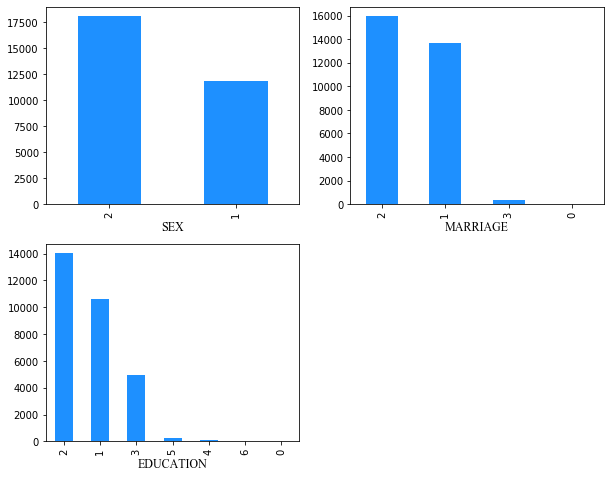

In [5]:
#plot distribution of each categorical variable
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 12}

plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
df.SEX.value_counts().plot(kind = 'bar',color="dodgerblue")
plt.xlabel("SEX",font)


plt.subplot(2, 2, 2)
df.MARRIAGE.value_counts().plot(kind = 'bar', color="dodgerblue")
plt.xlabel("MARRIAGE",font)

plt.subplot(2, 2, 3)
df.EDUCATION.value_counts().plot(kind = 'bar',color="dodgerblue")
plt.xlabel("EDUCATION",font)


UCI infomation shows here:
* SEX: Gender (1 = male, 2 = female)
* EDUCATION: (1 = graduate school, 2 = university, 3 = high school, 4 = others)
* MARRIAGE: Marital status (1 = married, 2 = single, 3 = others)

* Based on the figures shown above, it seems that Marriage and Education have values lacking definition, such as some undocumented labels (MARRIAGE = 0, EDUCATION = 0) and some unknown labels (EDUCATION = 5, EDUCATION = 6).This issue can be resolved in data cleaning part. 

### 2.2  Numerical features 
* There are 20 numerical features,which can be grouped into five groups. I will check the distribution of each of them.

#### 2.2.1 LIMIT_BAL: Amount of given credit in NT dollars (1 feature)

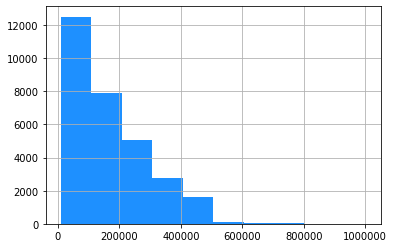

In [6]:
df.LIMIT_BAL.hist(color="dodgerblue")

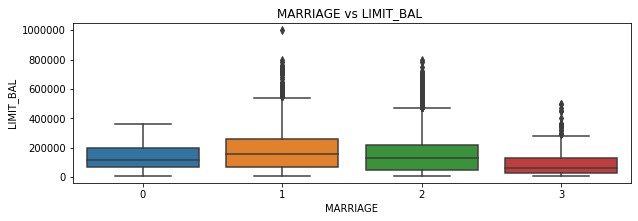

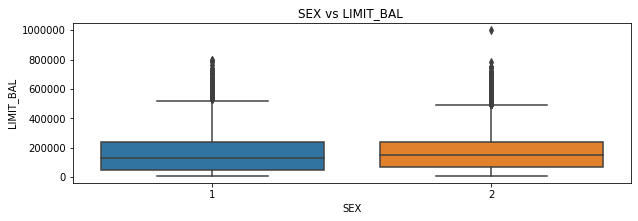

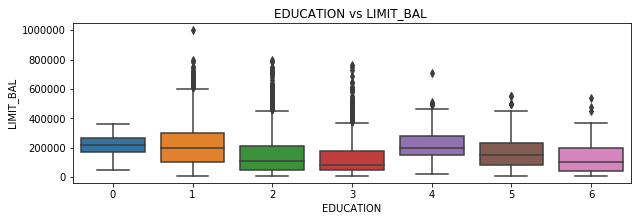

In [7]:
# check relation between LIMIT_BAL and 'MARRIAGE', 'SEX', and 'EDUCATION'
a = 1
for i in ['MARRIAGE', 'SEX', 'EDUCATION']:
    plt.figure(figsize=(10,10))
    plt.subplot(3,1,a)
    sns.boxplot(data=df, y='LIMIT_BAL', x=i)
    plt.title(i + ' vs LIMIT_BAL ')
plt.show()

Notes:
* MARRIGE: married customers (1 = married) have average higher credit limit
* Gender is less likely to effect much on credit limit
* Customers with graduate education (graduate school= 1) and OTHERS (4) class have higher credit limit on average.

#### 2.2.2 AGE:  year (1 feature)

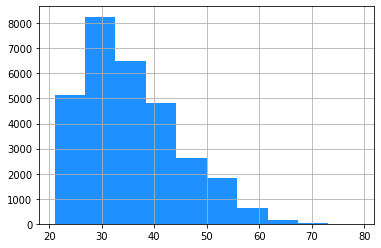

In [8]:
df.AGE.hist(color="dodgerblue")

#### 2.2.3 Repayment status (6 features)
* Features:'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
* Scale: -1=pay duly , 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above

In [9]:
df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


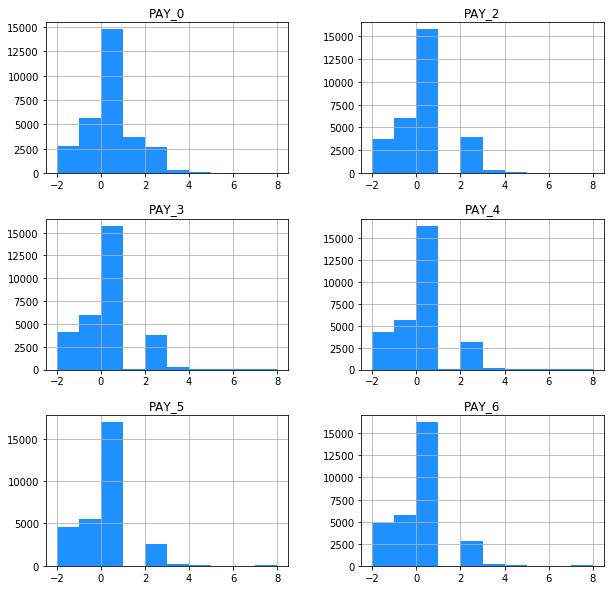

In [15]:
# plot histogram of repayment status
df_pay= df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
df_pay.hist(figsize=(10,10), bins=10, color="dodgerblue");

Notes:
* From PAY_0 to PAY_6, label '-2','-1'and '0' in repayment status, according to UCI, 1, 2, 3, ..., 8 are the months of delay, all indicate 'pay duly'. It could be grouped. This issue can be dealt with in data cleaning part.

#### 2.2.4 Amount of bill statement (6 features) 
* Features:'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'
* Scale: NT dollar

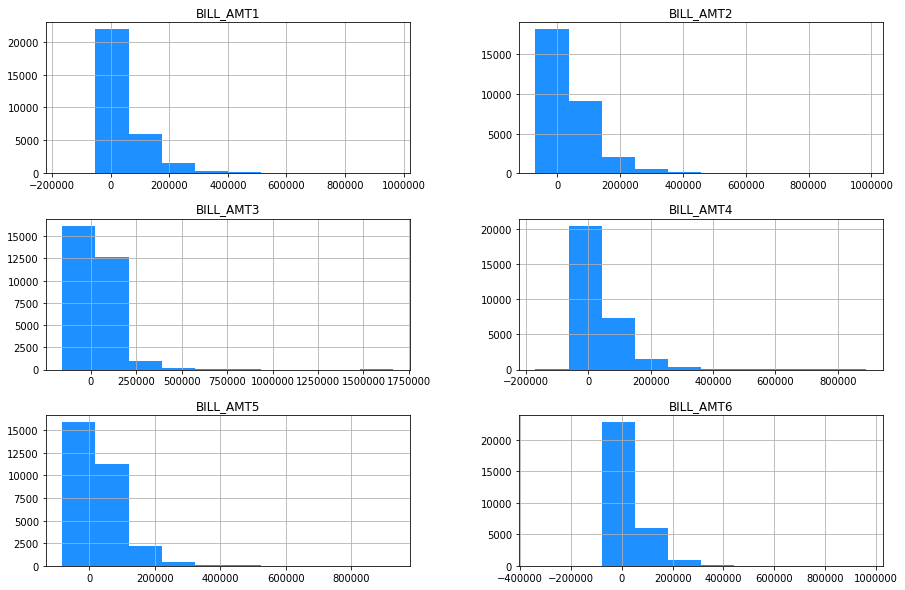

In [16]:
# plot histogram of bill statement
df_bills = df[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
df_bills.hist(figsize=(15,10), bins=10, color="dodgerblue");

#### 2.2.5 Amount of previous payment (6 features) 
* Features: 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
* Scale: NT dollar

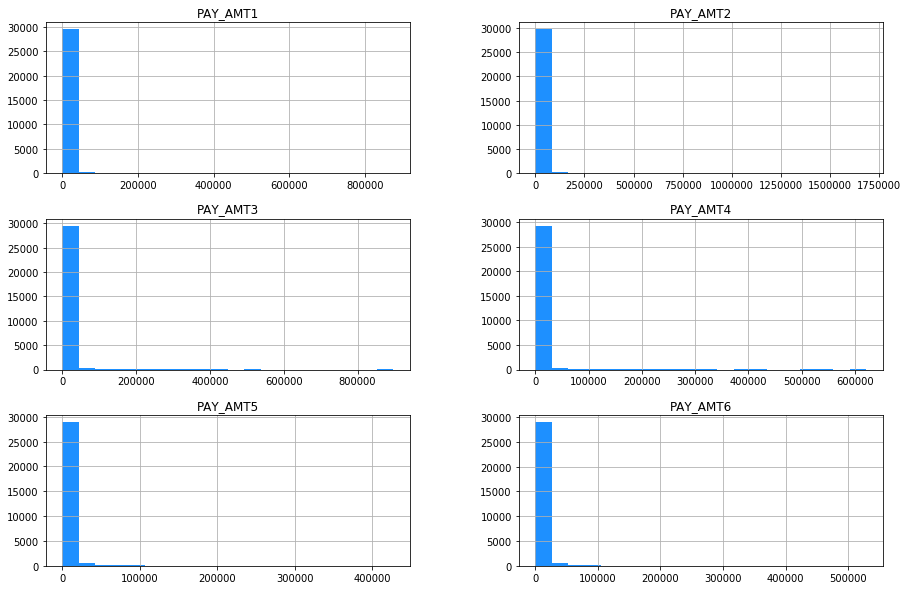

In [17]:
df_pay_amt = df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
df_pay_amt.hist(figsize=(15,10), bins=20, color="dodgerblue");

*  All these 20 plots above show that all the numerical variables are skewed distributed.

### 2.3 Response Variable

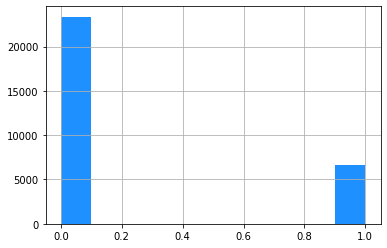

In [18]:
df.Default_y.hist(color="dodgerblue")

Notes:
* This dataset has more samples for 'No default' group (Default_y == 0), which means it tends to be imbalanced. 
* However, from experience, the group can be viewed as normal if it is between 20%~80% of the amount.Hence, I will not deal with imbalanced data in this case.

## 3. Data cleaning 
* As I menthioned before, I find Marriage and Education have undefined values and undocumented labels in Repayment status. I will resolve these parts before model training.

### 3.1 Marriage and Education
* I will categorized these undocumented labels (MARRIAGE = 0, EDUCATION = 0) and unknown labels (EDUCATION = 5, EDUCATION = 6) as "others" group because of the following reasons: 
(1) sample size of each undocumented/unknown label is small and then I can group them
(2) It is chanllenging to interprete these undocumented or unknown labels 

In [19]:
# group undocumented labels in MARRIAGE to group 3
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3

# group undocumented labels in EDUCATION to group 4
edu_un = (df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0)
df.loc[edu_un, 'EDUCATION'] = 4

Text(0.5, 0, 'EDUCATION')

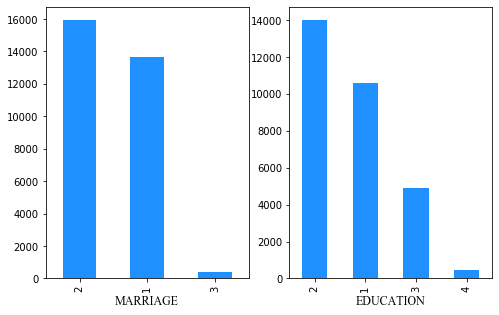

In [20]:
#plot distribution of updated "MARRIAGE" and "EDUCATION"
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
df.MARRIAGE.value_counts().plot(kind = 'bar',color="dodgerblue")
plt.xlabel("MARRIAGE", font)

plt.subplot(1, 2, 2)
df.EDUCATION.value_counts().plot(kind = 'bar',color="dodgerblue")
plt.xlabel("EDUCATION", font)

### 3.2 Repayment status 
* I combine 'PAY = -2, -1' to 'PAY = 0', which means there is no delay time, to reduce values uneasy to interpret.

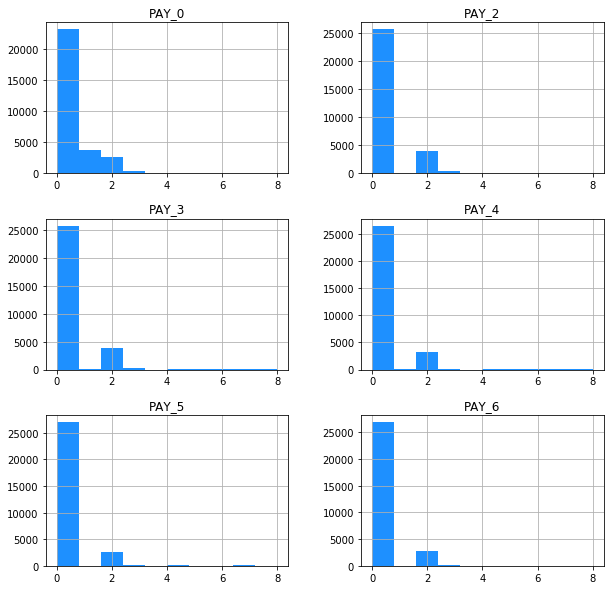

In [21]:
# Transform the value group'-2', '0', and '-1' to group'PAY = 0'
un = (df.PAY_0 == -2) | (df.PAY_0 == -1) | (df.PAY_0 == 0)
df.loc[un, 'PAY_0'] = 0
un = (df.PAY_2 == -2) | (df.PAY_2 == -1) | (df.PAY_2 == 0)
df.loc[un, 'PAY_2'] = 0
un = (df.PAY_3 == -2) | (df.PAY_3 == -1) | (df.PAY_3 == 0)
df.loc[un, 'PAY_3'] = 0
un = (df.PAY_4 == -2) | (df.PAY_4 == -1) | (df.PAY_4 == 0)
df.loc[un, 'PAY_4'] = 0
un = (df.PAY_5 == -2) | (df.PAY_5 == -1) | (df.PAY_5 == 0)
df.loc[un, 'PAY_5'] = 0
un = (df.PAY_6 == -2) | (df.PAY_6 == -1) | (df.PAY_6 == 0)
df.loc[un, 'PAY_6'] = 0

pay = df[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
pay.hist(figsize=(10,10), bins=10, color="dodgerblue");

### 3.3 Gender
* I transform the original value "1" and "2" into "0" and "1" respectively considering that "0" and "1" can be viewed as bianary charactor to fit the model directly.

In [22]:
#Transform value group "1" and "2" to "0" and "1" respectively.
sex = (df.SEX == 1)
df.loc[sex, 'SEX'] = 0
sex = (df.SEX == 2)
df.loc[sex, 'SEX'] = 1

## 4. Correlation exploration 

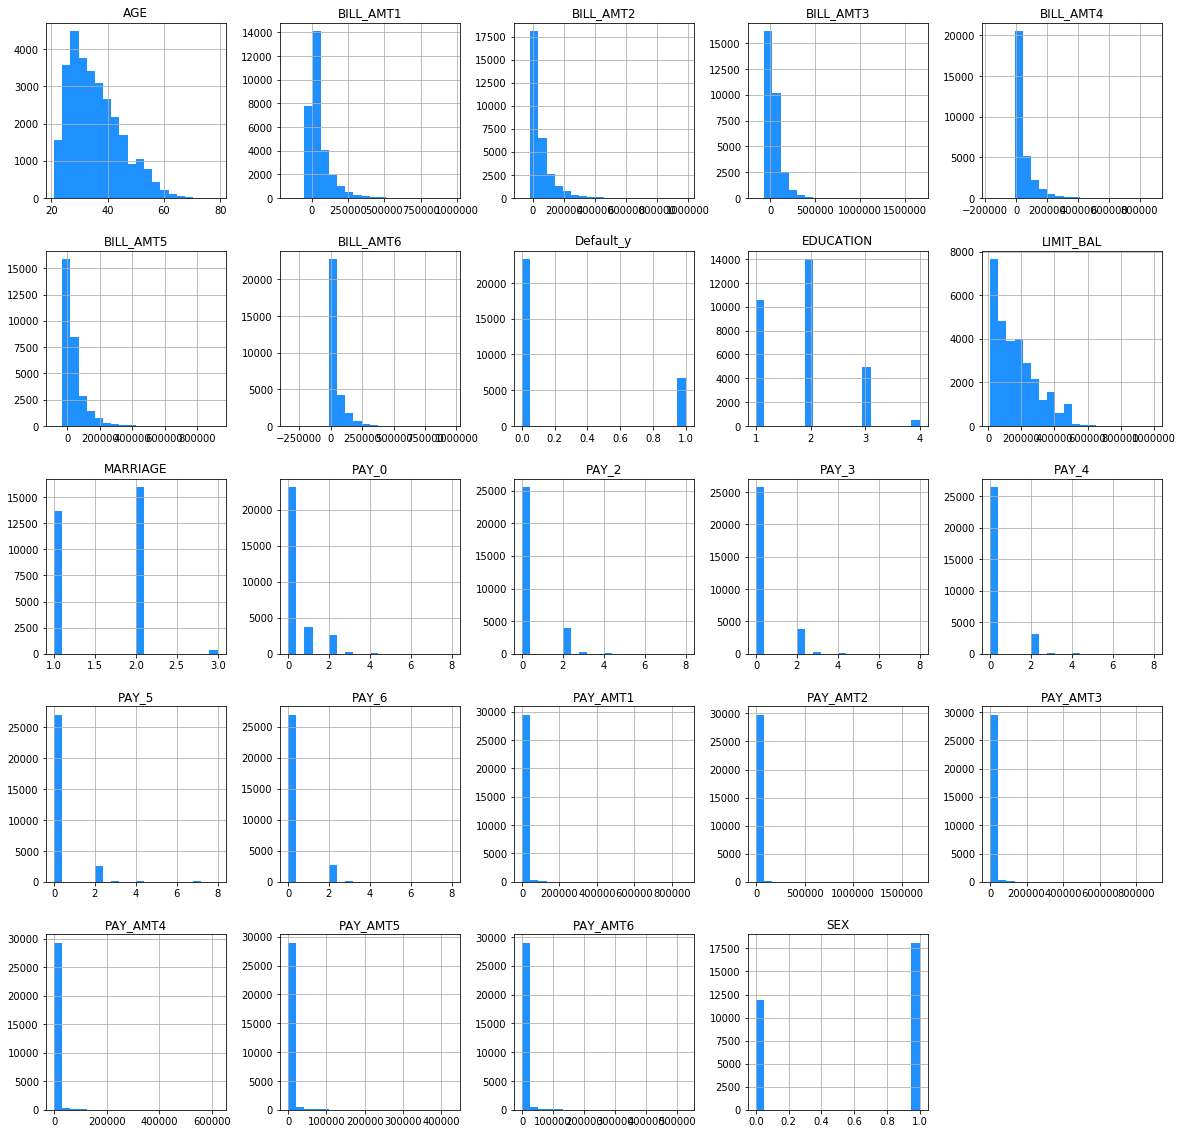

In [23]:
# Plot histograms for each variable after data cleaning 
df.hist(figsize=(20,20), bins=20,color="dodgerblue");

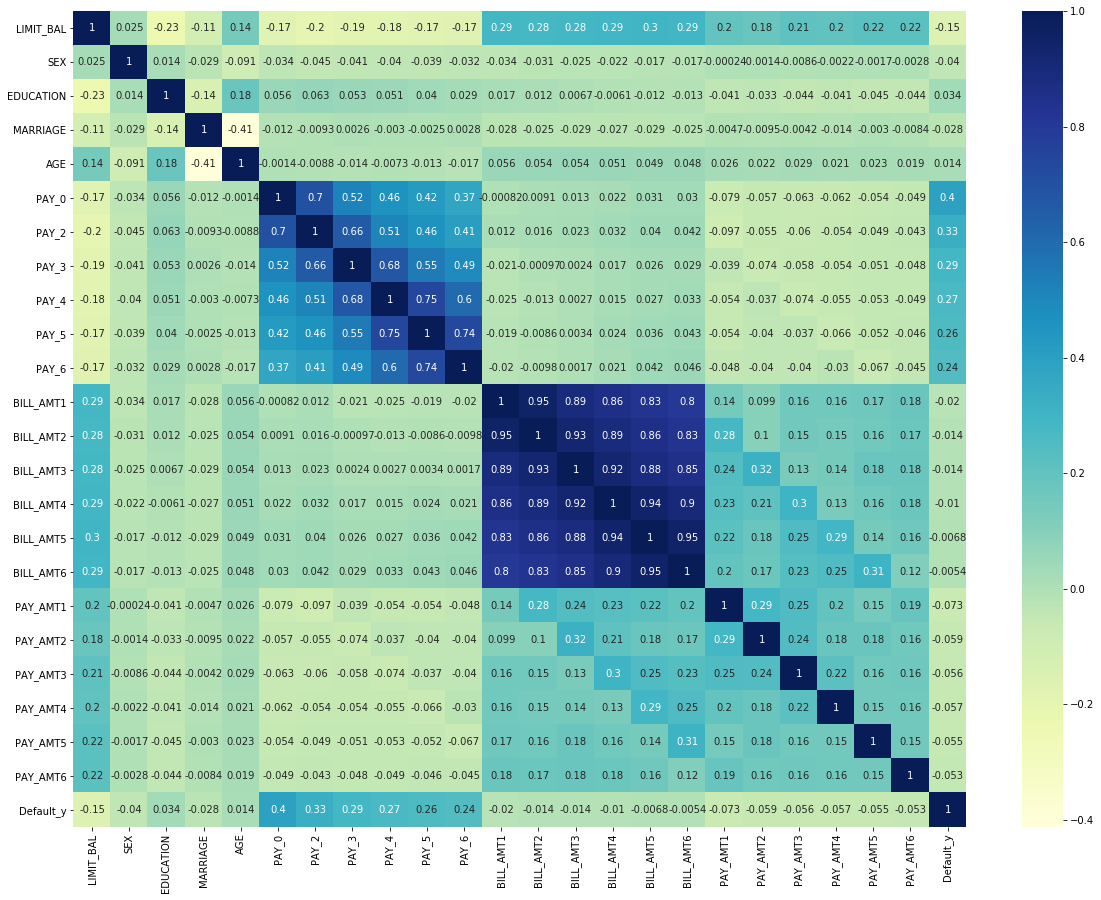

In [24]:
# Plot the correlation matrix. It only shows linear relationships here. 
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu");

Notes:
* BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, & BILL_AMT6 are strongly correlated mutually.
* PAY_0, PAY_2, PAY_3, PAY_4, PAY_5 & PAY_6 are highly correlated mutually.
* From the correlation contrix, Default_y have relatively high positive correlation with Pay_1, Pay_2,..Pay_i variables which means repay  status of  September to April. 

## 5. Model building and optimization 
Firstly, I split the dataset into training and test dataset.
Then I build 4 types of model for binary Classification to fit and then optimize. After comparing the performance of each model, the optimal model can be selected to predict the defaulter and identify the feature importance.
The Pros & cons of the 4 models are listed below:
* Logistic Regression: -- Simple to implement\ Easy to interpret feature importance\ Feature scaling not required\ Easy to overfit
* Neural Network:-- "Black box" \High quality\ Good fault tolerance capacity\ Uneasy to identify feature importance\ Small data size may lead to poor performance
* Random Forests、XGboost:-- Tree-based Ensemble method\ Relatively insensitive to skewed data\ Resolution for overfitting\ Performance promotion

Then, to evaluate the model performance, I will plot ROC curve to find the optimal threshold for probability cutoff and apply it to optimize the binary classification prediction.

Finaly,I will confirm the confusion matrix, F1 score and AUC (ROC curves) more than Accuracy, considering that it is unrobust to use accuracy as the evaluation metric for imbalanced dataset.

### 5.1 Feature Engineering

#### 5.1.1 Dummy transformation for catergorical features
* The categorical features "MARRAGE" and "EDUCATION" having more than 2 value groups shoul be converted to dummy variables.

In [25]:
# Dummy coding for 'MARRIAGE' & 'EDUCATION'
X = pd.get_dummies(data=df, columns=['MARRIAGE', 'EDUCATION'])

#Seperate the response variable
X.drop(columns=['Default_y'], axis=1, inplace=True)
y = df['Default_y']

X.head(5)

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4
0,20000,1,24,2,2,0,0,0,0,3913,...,0,0,0,1,0,0,0,1,0,0
1,120000,1,26,0,2,0,0,0,2,2682,...,1000,0,2000,0,1,0,0,1,0,0
2,90000,1,34,0,0,0,0,0,0,29239,...,1000,1000,5000,0,1,0,0,1,0,0
3,50000,1,37,0,0,0,0,0,0,46990,...,1100,1069,1000,1,0,0,0,1,0,0
4,50000,0,57,0,0,0,0,0,0,8617,...,9000,689,679,1,0,0,0,1,0,0


#### 5.1.2 Scaling 

In [26]:
#Standardization
X_standard = X[['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]
S = preprocessing.StandardScaler().fit(X_standard)

X.loc[:,['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']] = S.transform(X_standard)

X.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4
0,-1.136720,1,-1.246020,2,2,0,0,0,0,-0.642501,...,-0.308063,-0.314136,-0.293382,1,0,0,0,1,0,0
1,-0.365981,1,-1.029047,0,2,0,0,0,2,-0.659219,...,-0.244230,-0.314136,-0.180878,0,1,0,0,1,0,0
2,-0.597202,1,-0.161156,0,0,0,0,0,0,-0.298560,...,-0.244230,-0.248683,-0.012122,0,1,0,0,1,0,0
3,-0.905498,1,0.164303,0,0,0,0,0,0,-0.057491,...,-0.237846,-0.244166,-0.237130,1,0,0,0,1,0,0
4,-0.905498,0,2.334029,0,0,0,0,0,0,-0.578618,...,0.266434,-0.269039,-0.255187,1,0,0,0,1,0,0


In [28]:
#Normalization
X_norm = X[['LIMIT_BAL','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]
norm = preprocessing.MinMaxScaler().fit(X_norm)
X.loc[:,['LIMIT_BAL','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']] = norm.transform(X_norm)

X.head(5)


,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4
0,0.010101,1,0.051724,0.25,0.25,0.0,0.0,0.0,0.00,0.149982,...,0.000000,0.000000,0.000000,1,0,0,0,1,0,0
1,0.111111,1,0.086207,0.00,0.25,0.0,0.0,0.0,0.25,0.148892,...,0.001610,0.000000,0.003783,0,1,0,0,1,0,0
2,0.080808,1,0.224138,0.00,0.00,0.0,0.0,0.0,0.00,0.172392,...,0.001610,0.002345,0.009458,0,1,0,0,1,0,0
3,0.040404,1,0.275862,0.00,0.00,0.0,0.0,0.0,0.00,0.188100,...,0.001771,0.002506,0.001892,1,0,0,0,1,0,0
4,0.040404,0,0.620690,0.00,0.00,0.0,0.0,0.0,0.00,0.154144,...,0.014493,0.001615,0.001284,1,0,0,0,1,0,0


### 5.2 Split the dataset

In [29]:
# Split the dataset into training(75%) and test(25%) datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
print("Variables in Train Set : {} & Test Set : {}".format(len(X_train), len(X_test)))


Variables in Train Set : 22500 & Test Set : 7500


In [30]:
X_train.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4
18035,0.090909,0,0.293103,0.25,0.00,0.00,0.00,0.00,0.00,0.241192,...,0.001850,0.023445,0.000000,0,1,0,0,1,0,0
214,0.464646,0,0.103448,0.25,0.25,0.25,0.25,0.00,0.00,0.408952,...,0.016882,0.025410,0.019610,0,1,0,0,1,0,0
691,0.161616,0,0.103448,0.00,0.25,0.25,0.00,0.00,0.00,0.147554,...,0.000000,0.000000,0.000000,0,1,0,0,1,0,0
4583,0.101010,0,0.568966,0.25,0.25,0.25,0.25,0.25,0.25,0.196815,...,0.003704,0.005627,0.000000,1,0,0,0,1,0,0
19185,0.060606,1,0.051724,0.00,0.00,0.00,0.00,0.00,0.00,0.176253,...,0.003221,0.003702,0.005451,1,0,0,0,1,0,0


In [31]:
X_test.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4
10734,0.444444,0,0.396552,0.000,0.00,0.00,0.00,0.00,0.00,0.164174,...,0.003232,0.009423,0.000965,1,0,0,0,1,0,0
14908,0.202020,0,0.241379,0.000,0.00,0.25,0.00,0.00,0.00,0.146870,...,0.000638,0.000928,0.000749,1,0,0,0,1,0,0
4329,0.141414,1,0.051724,0.125,0.00,0.00,0.00,0.00,0.00,0.146519,...,0.016103,0.000000,0.000000,0,1,0,0,1,0,0
1428,0.202020,1,0.275862,0.250,0.25,0.25,0.25,0.25,0.25,0.213849,...,0.004026,0.007971,0.008134,1,0,0,1,0,0,0
17594,0.040404,1,0.206897,0.000,0.00,0.00,0.00,0.25,0.25,0.182568,...,0.000000,0.006565,0.002648,1,0,0,0,1,0,0


### 5.3 Logistic Regression model 

In [39]:
#Build Logistic Regression model and use penalty = 'l1' to avoid overfit
model_lr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=500). fit( X_train, y_train)

In [40]:
y_pred_l = model_lr.predict(X_test)

In [41]:
# Performance Evaluation
cm = confusion_matrix(y_test, y_pred_l)
roc_auc = roc_auc_score(y_test, y_pred_l)
print("Classification Report :- \n",classification_report(y_test, y_pred_l))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      5841
           1       0.68      0.33      0.45      1659

    accuracy                           0.82      7500
   macro avg       0.76      0.64      0.67      7500
weighted avg       0.80      0.82      0.79      7500

ROC AUC: 0.6441088173549019
Confusion Matrix:
[[5581  260]
 [1107  552]]


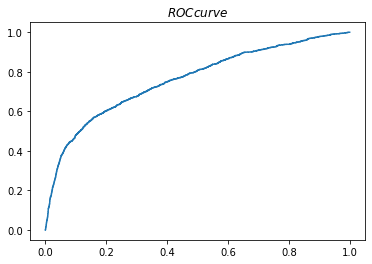

Optimal threshold： 0.21790101547788998


In [47]:
#Pot ROC to find the optimal threshold value
y_pre=model_lr.predict_proba(X_test)
y_0=list(y_pre[:,1]) 
fpr,tpr,thresholds = metrics.roc_curve(y_test,y_0) 
auc=roc_auc_score(y_test,y_0) 

plt.figure()
plt.plot(fpr,tpr)
plt.title('$ROC curve$')
plt.show()

KS_max=0
best_thr=0
for i in range(len(fpr)):
    if(i==0):
        KS_max=tpr[i]-fpr[i]
        best_thr=thresholds[i]   
    elif (tpr[i]-fpr[i]>KS_max):
        KS_max= tpr[i] -fpr[i]
        best_thr=thresholds[i]
        
print('Optimal threshold：',best_thr)


In [48]:
#Use the optimal threshold to reproduce the prediction
thres = 0.218
y_pred_l = np.where(y_pre[:,1] > thres,1,0)
y_pred_l

array([0, 0, 1, ..., 0, 0, 0])

In [88]:
# Performance Improvement
cm = confusion_matrix(y_test, y_pred_l)
roc_auc = roc_auc_score(y_test, y_pred_l)
print("Classification Report :- \n",classification_report(y_test, y_pred_l))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.87      0.84      0.86      5841
           1       0.50      0.57      0.53      1659

    accuracy                           0.78      7500
   macro avg       0.69      0.70      0.69      7500
weighted avg       0.79      0.78      0.78      7500

ROC AUC: 0.7046868600183339
Confusion Matrix:
[[4905  936]
 [ 714  945]]


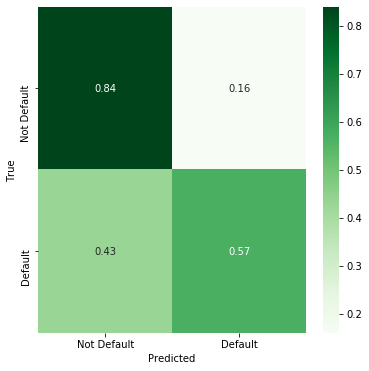

In [89]:
#Creat Confusion Matrix
confusion_matrix_xg = confusion_matrix(y_test, y_pred_l)
# Turn matrix to percentages
confusion_matrix_xg = confusion_matrix_xg.astype('float') / confusion_matrix_xg.sum(axis = 1)[:, np.newaxis]
 
# Turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_xg, index = ['Not Default', 'Default'], columns = ['Not Default', 'Default'])
 
# Create image
plt.figure(figsize=(6,6))
heatmap = sns.heatmap(df_cm, annot = True, fmt = '.2f',linecolor = "Darkblue", cmap = "Greens",
            yticklabels = ['Not Default', 'Default'],)

plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

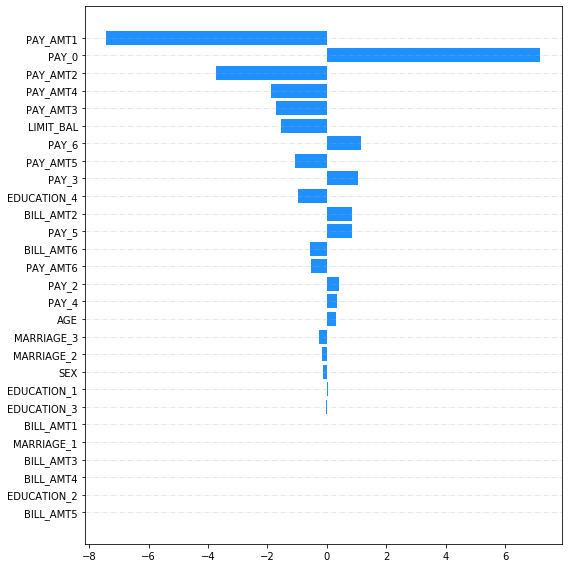

In [90]:
#Feature Importance 

coef_lr = pd.DataFrame({'var' : X_test.columns,

'coef' : model_lr.coef_.flatten()

})

index_sort = np.abs(coef_lr['coef']).sort_values().index

coef_lr_sort = coef_lr.loc[index_sort,:]


fig,ax=plt.subplots(figsize = (8,8))

x, y = coef_lr_sort['var'], coef_lr_sort['coef']

rects = plt.barh(x, y, color='dodgerblue')

plt.grid(linestyle="-.", axis='y', alpha=0.4)

plt.tight_layout()




Notes:
* "BILL_AMTi", which represents the amount of bill statement for each month, shows extremely low feature importance. 
* "PAY_0", which describes the repayment status for September, with "PAY_AMT1" and "PAY_AMT2", which mean amount of previous payment for September and August respectively, contribute the most importance to the prediction. 
* Besides, Age, gender and marriage have tiny effect on the prediciton.

### 5.4 Neural Network Model

In [92]:
nn = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', 
    solver='adam', alpha=0.0001, batch_size='auto', 
    learning_rate='constant',max_iter=1000)

In [93]:
nn.fit(X_train,y_train.astype('int'))
y_predict_N=nn.predict(X_test)

In [94]:
# Performance Evaluation
cm = confusion_matrix(y_test, y_predict_N)
roc_auc = roc_auc_score(y_test, y_predict_N)
print("Classification Report :- \n",classification_report(y_test, y_predict_N))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      5841
           1       0.65      0.38      0.48      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.66      0.69      7500
weighted avg       0.80      0.82      0.80      7500

ROC AUC: 0.6630051395123268
Confusion Matrix:
[[5506  335]
 [1023  636]]


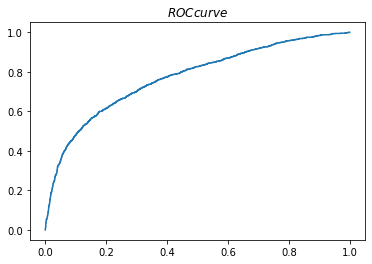

Optimal threshold： 0.24083063690640671


In [95]:
#Pot ROC to find the optimal threshold value

y_pb=nn.predict_proba(X_test)
y_0_nn=list(y_pb[:,1]) 
fpr,tpr,thresholds = metrics.roc_curve(y_test,y_0_nn) 
auc=roc_auc_score(y_test,y_0_nn) 

plt.figure()
plt.plot(fpr,tpr)
plt.title('$ROC curve$')
plt.show()
KS_max=0
best_thr=0

for i in range(len(fpr)):
    if(i==0):
        KS_max=tpr[i]-fpr[i]
        best_thr=thresholds[i]
    elif (tpr[i]-fpr[i]>KS_max):
        KS_max= tpr[i] -fpr[i]
        best_thr=thresholds[i]
        
print('Optimal threshold：',best_thr)

In [96]:
#Use the optimal threshold to reproduce the prediction
thres = 0.24
y_predict_N = np.where(y_pb[:,1] > thres,1,0)
y_predict_N

array([0, 0, 0, ..., 0, 0, 0])

In [97]:
# Performance Improvement
cm = confusion_matrix(y_test, y_predict_N)
roc_auc = roc_auc_score(y_test, y_predict_N)
print("Classification Report :- \n",classification_report(y_test, y_predict_N))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      5841
           1       0.49      0.60      0.54      1659

    accuracy                           0.77      7500
   macro avg       0.68      0.71      0.69      7500
weighted avg       0.79      0.77      0.78      7500

ROC AUC: 0.7102543812477302
Confusion Matrix:
[[4794 1047]
 [ 664  995]]


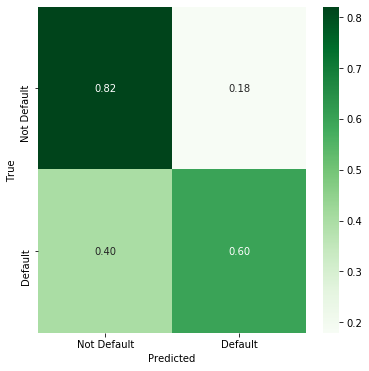

In [98]:
#Creat Confusion Matrix
confusion_matrix_xg = confusion_matrix(y_test, y_predict_N)
# Turn matrix to percentages
confusion_matrix_xg = confusion_matrix_xg.astype('float') / confusion_matrix_xg.sum(axis = 1)[:, np.newaxis]
 
# Turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_xg, index = ['Not Default', 'Default'], columns = ['Not Default', 'Default'])
 
# Create image
plt.figure(figsize=(6,6))
heatmap = sns.heatmap(df_cm, annot = True, fmt = '.2f',linecolor = "Darkblue", cmap = "Greens",
            yticklabels = ['Not Default', 'Default'],)

plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

### 5.3 Random Forest model 

In [59]:
# Create random forest with initial parameters.
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [60]:
# set up parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 35, 60, 85, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [61]:
# Use the random grid to search for best hyperparameters
rf_random = RandomizedSearchCV(estimator = model_rf, 
                               param_distributions = random_grid, 
                               n_iter = 50,  
                               cv = 3,          
                               verbose=2, 
                               random_state=42, 
                               n_jobs = 1
                              )
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True, total=  35.3s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.2s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True, total=  35.9s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True, total=  35.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=  32.8s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=  32.9s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=400, min_

[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  16.4s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=35, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=35, bootstrap=False, total= 1.2min
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=35, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=35, bootstrap=False, total= 1.2min
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=35, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=35, bootstrap=False, total= 1.2min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=35, bootstrap=True 
[CV]  n_estimators=400, min_

[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True, total=  38.6s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True, total=  35.9s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True, total=  33.1s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=  31.5s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=4

[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=35, bootstrap=True, total=  43.2s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=35, bootstrap=True 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=35, bootstrap=True, total=  43.1s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=False, total=  25.5s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=False, total=  24.3s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=300, min_sam

[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=35, bootstrap=True, total=  20.8s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=  10.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=  11.1s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=  10.3s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=200, min_sa

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 77.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [63]:
# check the best parameters
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [64]:
# Create random forest model with updated parameters.
model_rf1 = RandomForestClassifier(n_estimators=100, # Number of trees to train
                       criterion = 'entropy', 
                       max_depth = None, 
                       min_samples_split = 5, 
                       min_samples_leaf = 4, 
                       max_features = 'sqrt', 
                       min_impurity_decrease = 0.0001, 
                       bootstrap = True,
                       n_jobs = 8, # Parallel processing. 
                       verbose = 1, #  Set to 0 for silent training.
                       class_weight = 'balanced' # Balance the classes.
                    )

model_rf1.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='sqrt', min_impurity_decrease=0.0001,
                       min_samples_leaf=4, min_samples_split=5, n_jobs=8,
                       verbose=1)

In [65]:
y_pred1 = model_rf1.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [66]:
# Performance Evaluation
cm = confusion_matrix(y_test, y_pred1)
roc_auc = roc_auc_score(y_test, y_pred1)
print("Classification Report :- \n",classification_report(y_test, y_pred1))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      5841
           1       0.56      0.52      0.54      1659

    accuracy                           0.80      7500
   macro avg       0.71      0.70      0.71      7500
weighted avg       0.80      0.80      0.80      7500

ROC AUC: 0.7035653683368767
Confusion Matrix:
[[5163  678]
 [ 791  868]]


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


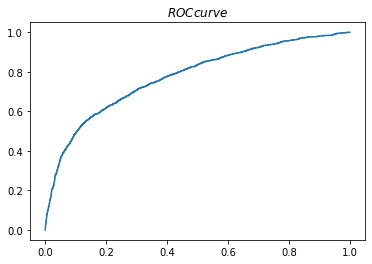

Optimal threshold： 0.41457557315316473


In [67]:
#Pot ROC to find the optimal threshold value

y_pr_rf=model_rf1.predict_proba(X_test)
y_0_rf=list(y_pr_rf[:,1]) 
fpr,tpr,thresholds = metrics.roc_curve(y_test,y_0_rf) 
auc=roc_auc_score(y_test,y_0_rf) 

plt.figure()
plt.plot(fpr,tpr)
plt.title('$ROC curve$')
plt.show()

KS_max=0
best_thr=0
for i in range(len(fpr)):
    if(i==0):
        KS_max=tpr[i]-fpr[i]
        best_thr=thresholds[i]
    elif (tpr[i]-fpr[i]>KS_max):
        KS_max= tpr[i] -fpr[i]
        best_thr=thresholds[i]
        
print('Optimal threshold：',best_thr)

In [68]:
#Use the optimal threshold to reproduce the prediction
thres = 0.415
y_pred1 = np.where(y_pr_rf[:,1] > thres,1,0)
y_pred1

array([0, 1, 0, ..., 0, 0, 0])

In [69]:
# Performance Improvement
cm = confusion_matrix(y_test, y_pred1)
roc_auc = roc_auc_score(y_test, y_pred1)
print("Classification Report :- \n",classification_report(y_test, y_pred1))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      5841
           1       0.51      0.58      0.54      1659

    accuracy                           0.78      7500
   macro avg       0.69      0.71      0.70      7500
weighted avg       0.79      0.78      0.79      7500

ROC AUC: 0.7110641152692215
Confusion Matrix:
[[4895  946]
 [ 690  969]]


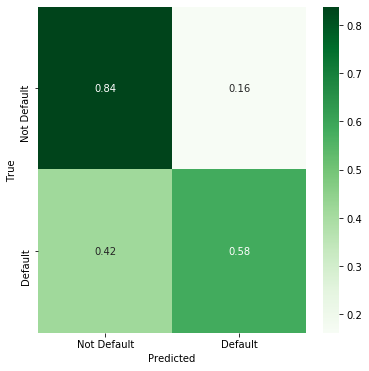

In [70]:
#Creat Confusion Matrix
confusion_matrix_xg = confusion_matrix(y_test, y_pred1)
# Turn matrix to percentages
confusion_matrix_xg = confusion_matrix_xg.astype('float') / confusion_matrix_xg.sum(axis = 1)[:, np.newaxis]
 
# Turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_xg, index = ['Not Default', 'Default'], columns = ['Not Default', 'Default'])
 
# Create image
plt.figure(figsize=(6,6))
heatmap = sns.heatmap(df_cm, annot = True, fmt = '.2f',linecolor = "Darkblue", cmap = "Greens",
            yticklabels = ['Not Default', 'Default'],)

plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

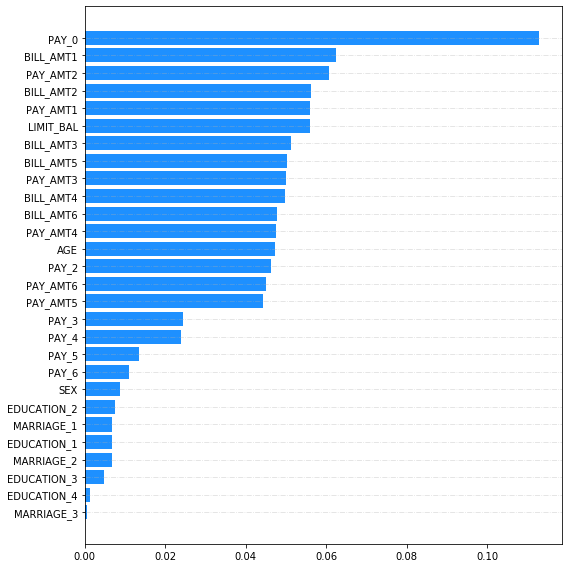

In [71]:
#Feature Importance
importances = model_rf1.feature_importances_


coef_lr = pd.DataFrame({'var' : X_test.columns,

'coef' : importances

})

index_sort = np.abs(coef_lr['coef']).sort_values().index

coef_lr_sort = coef_lr.loc[index_sort,:]


fig,ax=plt.subplots(figsize = (8,8))

x, y = coef_lr_sort['var'], coef_lr_sort['coef']

rects = plt.barh(x, y, color='dodgerblue')

plt.grid(linestyle="-.", axis='y', alpha=0.4)

plt.tight_layout()

Notes:
* Random forest model shows "PAY_0" contribute the most importance to the prediction.
* "Bill_AMTi" and "LIMIT_BAL" also have relatively high feature importance.
* Catagorical variables, such as Education, Marrage, Gender and Age have extremely low importance.

### 5.4 XGboosting model 

In [72]:
# Generate simple XGboosting model with initial parameters.
model_xg = xgb.XGBClassifier(objective='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100)
model_xg.fit(X_train, y_train)

XGBClassifier(max_depth=5, objective='reg:squarederror')

In [73]:
y_pred_xg = model_xg.predict(X_test)

In [74]:
# Define the parameters
param_grid = dict({'n_estimators': [100, 150, 200],
                   'max_depth': [2, 3, 4],
                 'learning_rate' : [0.01, 0.05, 0.1, 0.15]
                  })

In [75]:
# Define grid search object.
GridXGB = GridSearchCV(model_xg,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 10,              # Number of cross-validation folds.  
                       scoring = 'recall', # How to rank outputs.
                       n_jobs = 1,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [76]:
GridXGB.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 19.8min finished


GridSearchCV(cv=10,
             estimator=XGBClassifier(max_depth=5, objective='reg:squarederror'),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 150, 200]},
             refit=False, scoring='recall', verbose=1)

In [77]:
# check the best parameters
print(GridXGB.best_params_.get('max_depth'))
print (GridXGB.best_params_.get('learning_rate'))
print(GridXGB.best_params_.get('n_estimators'))

3
0.15
150


In [78]:
# Create XGB with updated parameters.
model_xg1 = xgb.XGBClassifier(max_depth = 3,                # Depth of each tree (This should be between 3-10)
                            learning_rate = 0.15,            # How much to shrink error in each subsequent training
                            n_estimators = 150,             # How many trees to use
                            objective = 'binary:logistic',  # Type of target variable.
                            booster = 'gbtree',             # boost Trees 
                            n_jobs = 1,                     # Parallel jobs to run.
                            gamma = 0.01,                   # A smaller value like 0.01-0.02 can also be chosen for starting (Minimum loss reduction required for partition on a leaf node.
                            subsample = 0.75,               # Subsample ratio. Typical values range between 0.5-0.9
                            colsample_bytree = 0.8,         # Subsample ratio of columns when constructing each tree.Typical values range between 0.5-0.9
                            colsample_bylevel = 1,          # Subsample ratio of columns when constructing each level. 
                            colsample_bynode = 1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha = 1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda = 0,                 # Regularizer for first fit.
                            scale_pos_weight = 3,           # Balancing of positive and negative weights.
                            base_score = 0.5,               # Global bias. Set to average of the target rate.
                            random_state = 0,               # Seed
                            missing = 1,
                            use_label_encoder=False
                            )
model_xg1.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.8, gamma=0.01, learning_rate=0.15, missing=1,
              n_estimators=150, reg_alpha=1, reg_lambda=0, scale_pos_weight=3,
              subsample=0.75, use_label_encoder=False)

In [79]:
y_pred2 = model_xg1.predict(X_test)

In [80]:
# Performance Evaluation
cm = confusion_matrix(y_test, y_pred2)
roc_auc = roc_auc_score(y_test, y_pred2)
print("Classification Report :- \n",classification_report(y_test, y_pred2))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.88      0.83      0.86      5841
           1       0.50      0.60      0.55      1659

    accuracy                           0.78      7500
   macro avg       0.69      0.71      0.70      7500
weighted avg       0.80      0.78      0.79      7500

ROC AUC: 0.7147841550330287
Confusion Matrix:
[[4861  980]
 [ 668  991]]


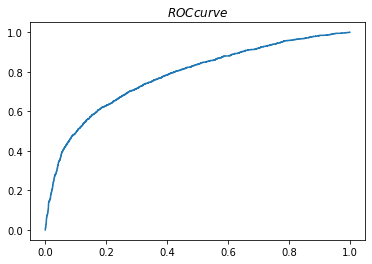

Optimal threshold： 0.48040703


In [81]:
#Pot ROC to find the optimal threshold value

from sklearn import metrics
Pr=model_xg1.predict_proba(X_test)
y_0_xgb=list(Pr[:,1]) 
fpr,tpr,thresholds = metrics.roc_curve(y_test,y_0_xgb) 
auc=roc_auc_score(y_test,y_0_xgb) 

plt.figure()
plt.plot(fpr,tpr)
plt.title('$ROC curve$')
plt.show()

KS_max=0
best_thr=0

for i in range(len(fpr)):
    if(i==0):
        KS_max=tpr[i]-fpr[i]
        best_thr=thresholds[i]    
    elif (tpr[i]-fpr[i]>KS_max):
        KS_max= tpr[i] -fpr[i]
        best_thr=thresholds[i]
        
print('Optimal threshold：',best_thr)

In [82]:
thres = 0.48
y_pred2 = np.where(Pr[:,1] > thres,1,0)
y_pred2

array([0, 1, 0, ..., 0, 0, 0])

In [83]:
# Performance Improvement
cm = confusion_matrix(y_test, y_pred2)
roc_auc = roc_auc_score(y_test, y_pred2)
print("Classification Report :- \n",classification_report(y_test, y_pred2))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.88      0.81      0.85      5841
           1       0.49      0.62      0.54      1659

    accuracy                           0.77      7500
   macro avg       0.68      0.72      0.70      7500
weighted avg       0.80      0.77      0.78      7500

ROC AUC: 0.7168206415149131
Confusion Matrix:
[[4751 1090]
 [ 630 1029]]


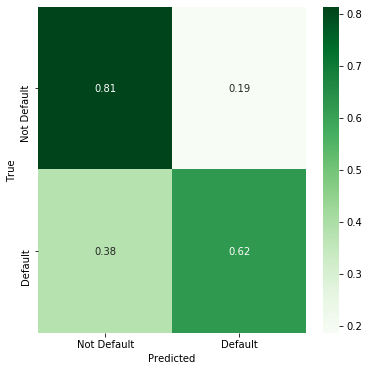

In [84]:
#Creat Confusion Matrix
confusion_matrix_xg = confusion_matrix(y_test, y_pred2)
# Turn matrix to percentages
confusion_matrix_xg = confusion_matrix_xg.astype('float') / confusion_matrix_xg.sum(axis = 1)[:, np.newaxis]
 
# Turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_xg, index = ['Not Default', 'Default'], columns = ['Not Default', 'Default'])
 
# Create image
plt.figure(figsize=(6,6))
heatmap = sns.heatmap(df_cm, annot = True, fmt = '.2f',linecolor = "Darkblue", cmap = "Greens",
            yticklabels = ['Not Default', 'Default'],)

plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

* I will use two methods to check features importance, which are Xgboost Built-in and SHAP Values(average impact of model outputs).

Text(0.5, 0, 'Xgboost Feature Importance')

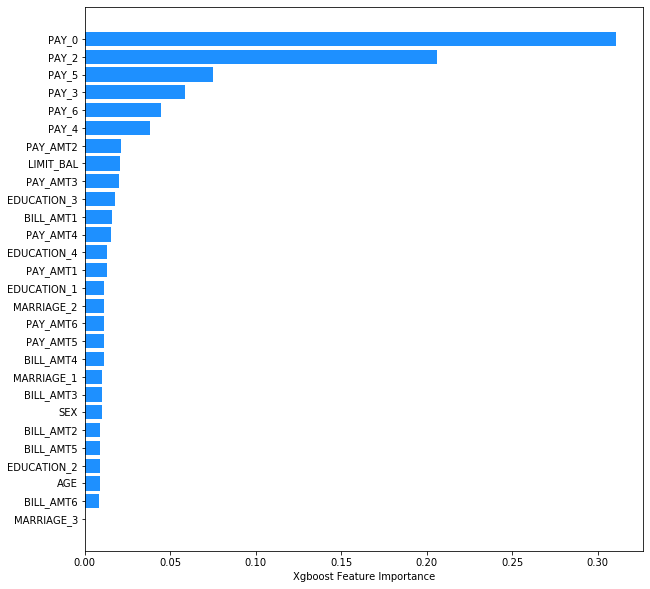

In [85]:
#1. Xgboost Built-in Feature Importance
fig, (ax) = plt.subplots(ncols=1, figsize=(10,10))
sorted_idx = model_xg1.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], model_xg1.feature_importances_[sorted_idx], color="dodgerblue")
plt.xlabel("Xgboost Feature Importance")

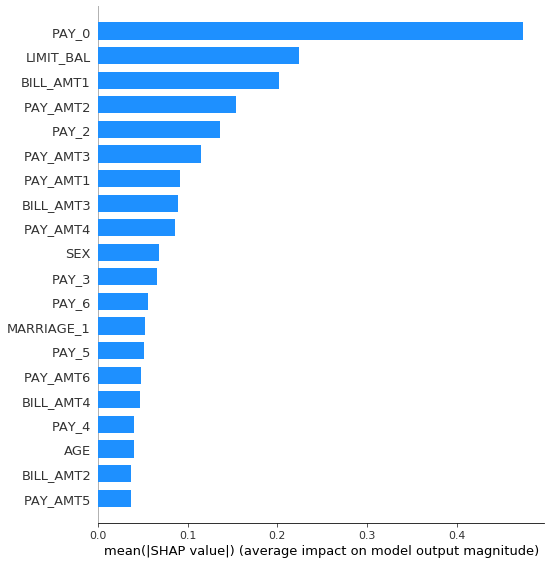

In [86]:
#2. Feature Importance Computed with SHAP Values
explainer = shap.TreeExplainer(model_xg1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", color="dodgerblue")

Summary:
* Logistic Regression model: 
ROC AUC: 0.70 
accuracy: 0.78
              precision    recall  f1-score   support
           0       0.87      0.84      0.86      5841
           1       0.50      0.57      0.53      1659


* Neural Network model: 
ROC AUC: 0.710
accuracy: 0.77 
                precision    recall  f1-score   support
           0       0.88      0.82      0.85      5841
           1       0.49      0.60      0.54      1659

           
* Random forest model: 
ROC AUC: 0.711
accuracy: 0.77
               precision    recall  f1-score   support
           0       0.88      0.84      0.86      5841
           1       0.51      0.58      0.54      1659


           
* XGboosting model: 
ROC AUC: 0.717
accuracy: 0.77
              precision    recall  f1-score   support
           0       0.88      0.81      0.85      5841
           1       0.49      0.62      0.54      1659



* All models have relatively low F1 score of 'Default' group. It seems be caused by imbalanced dataset issue due to that there are more samples in 'no Default' group.But we still compare the F1 score of 'default' due to that we more care about the classification power of 'Default' group.

* Comparing f1-score of 'Default', AUC and accuracy of each model, Xgboost model shows the highest performance and Ensemble method show slightly better performance than logistic regression and Neural Network model. The accuracy of each model has little difference while AUC of each one grows slightly from Logistic Regreesion to XGboost.

* PAY_0,BILL_AMT1, PAY_AMT2, and LIMIT_BAL, are considered as the most important features from features importance comparison.we can suggest the features with which clients are more likely to be defaulters, including higher limit balance, high bill amount and low pay amount in the latest few months.

Discussion:
* Plotting ROC curve to find the optimal threshold for binary clasification model will improve model performance evaluated by metric AUC primarily.
* Cross validation and hyperparameters tunning for models can actually improve model performance.
* Neural Network has limitation for small size data and uneasy to interpret the feature importance.
* Ensemble method will be good selection for binary classification model buiding.
